# 1. Import needed libraries

In [1]:
import os
import sys
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
# import torch
# from torchvision import transforms
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score;
from sklearn.model_selection import cross_val_score
#---------------------------------------
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")


# 2. Preprocessing

## 2.1 Load data

In [2]:
def load_train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [3]:
def load_test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [4]:
train_df = load_train_df('C:/Users/arshdeep/Desktop/STUDY MATERIAL/third_Year/dataset/Training')

In [5]:
train_df

,Class Path,Class
0,C:/Users/arshdeep/Desktop/STUDY MATERIAL/third...,glioma
1,C:/Users/arshdeep/Desktop/STUDY MATERIAL/third...,glioma
2,C:/Users/arshdeep/Desktop/STUDY MATERIAL/third...,glioma
3,C:/Users/arshdeep/Desktop/STUDY MATERIAL/third...,glioma
4,C:/Users/arshdeep/Desktop/STUDY MATERIAL/third...,glioma
...,...,...
5707,C:/Users/arshdeep/Desktop/STUDY MATERIAL/third...,pituitary
5708,C:/Users/arshdeep/Desktop/STUDY MATERIAL/third...,pituitary
5709,C:/Users/arshdeep/Desktop/STUDY MATERIAL/third...,pituitary
5710,C:/Users/arshdeep/Desktop/STUDY MATERIAL/third...,pituitary


In [6]:
test_df = load_test_df('C:/Users/arshdeep/Desktop/STUDY MATERIAL/third_Year/dataset/Testing')

In [7]:
test_df

,Class Path,Class
0,C:/Users/arshdeep/Desktop/STUDY MATERIAL/third...,glioma
1,C:/Users/arshdeep/Desktop/STUDY MATERIAL/third...,glioma
2,C:/Users/arshdeep/Desktop/STUDY MATERIAL/third...,glioma
3,C:/Users/arshdeep/Desktop/STUDY MATERIAL/third...,glioma
4,C:/Users/arshdeep/Desktop/STUDY MATERIAL/third...,glioma
...,...,...
1306,C:/Users/arshdeep/Desktop/STUDY MATERIAL/third...,pituitary
1307,C:/Users/arshdeep/Desktop/STUDY MATERIAL/third...,pituitary
1308,C:/Users/arshdeep/Desktop/STUDY MATERIAL/third...,pituitary
1309,C:/Users/arshdeep/Desktop/STUDY MATERIAL/third...,pituitary


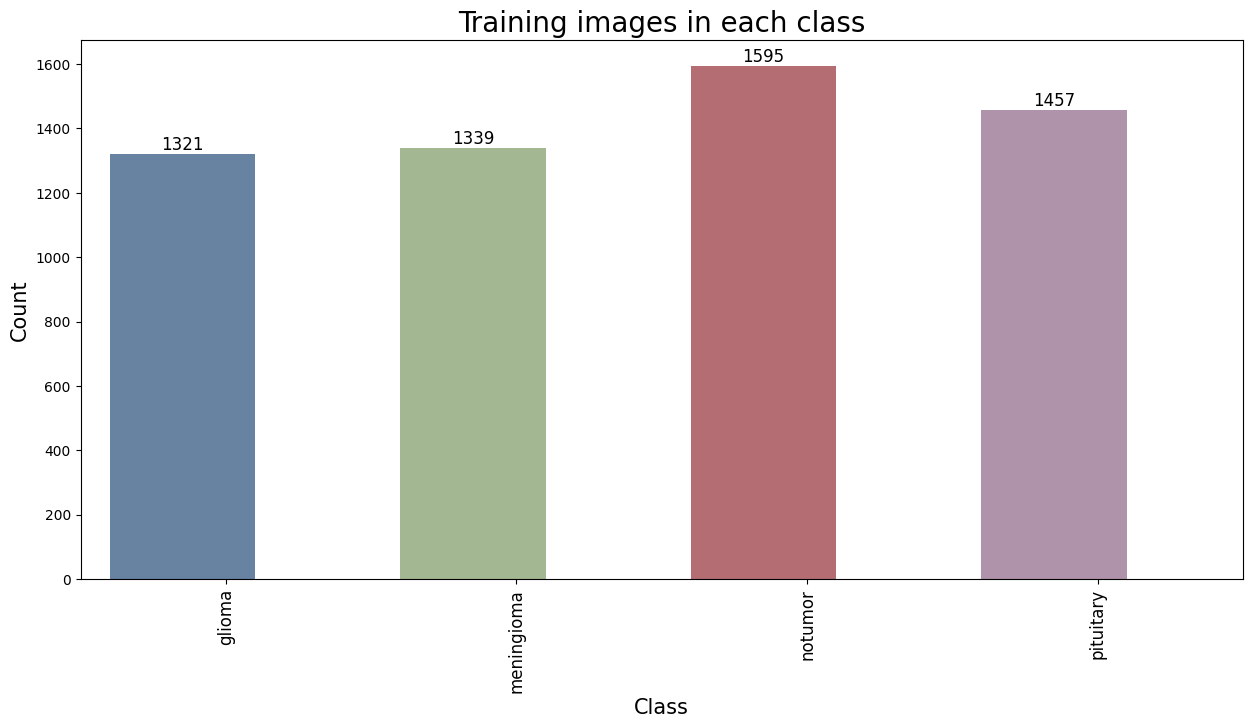

In [8]:
# Bar plot of images in each class in train data


# New color palette
color_1 = ['#5e81ac', '#a3be8c', '#bf616a', '#b48ead']
# Define the bar width
bar_width = 0.5  

# Create the figure
plt.figure(figsize=(15, 7))

# Bar plot with adjustable bar width
ax = sns.countplot(data=train_df, x='Class', palette=color_1, linewidth=1.5)

# Adjust the width of each bar
for bar in ax.patches:
    bar.set_width(bar_width)

# Adding the number of elements on top of each bar
for bar in ax.patches:
    ax.annotate(
        f"{int(bar.get_height())}",  # Display the height (count)
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position
        ha='center', va='bottom', fontsize=12, color='black'  # Text style
    )

# Adding labels and title
plt.xlabel('Class', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Training images in each class', fontsize=20)

# Rotate x-axis labels for readability
plt.xticks(rotation=90, fontsize=12)

# Show the plot
plt.show()


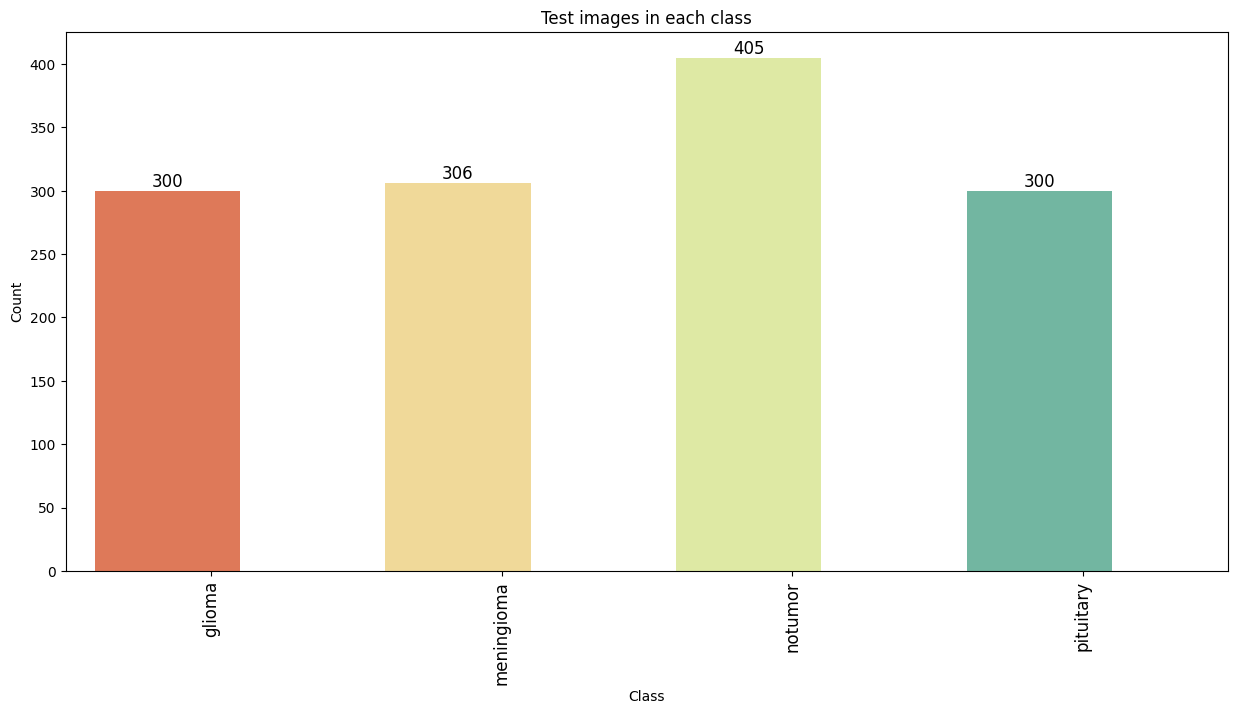

In [9]:
# Bar plot of images in each class in test data

# Adjust bar width for count plot
bar_width = 0.5  # Set the desired bar width
plt.figure(figsize=(15, 7))

# Bar plot with adjustable bar width
ax = sns.countplot(data=test_df, x='Class', palette='Spectral', linewidth=1.5)

# Adjust the width of each bar
for bar in ax.patches:
    bar.set_width(bar_width)

# Adding the number of elements on top of each bar
for bar in ax.patches:
    ax.annotate(
        f"{int(bar.get_height())}",  # Display the height (count)
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position
        ha='center', va='bottom', fontsize=12, color='black'  # Text style
    )

# Adding labels and title
ax.set(xlabel='Class', ylabel='Count', title='Test images in each class')

# Rotate x-axis labels
plt.xticks(rotation=90, fontsize=12)

# Show the plot
plt.show()


## 2.2 Split data into train, test, valid

In [10]:
from sklearn.model_selection import train_test_split

# Initial split into training and testing
train_df, test_split_df = train_test_split(train_df, test_size=0.3, random_state=42, stratify=train_df['Class'])


## 2.3 Data preprocessing

Found 3998 validated image filenames belonging to 4 classes.
Found 1714 validated image filenames belonging to 4 classes.


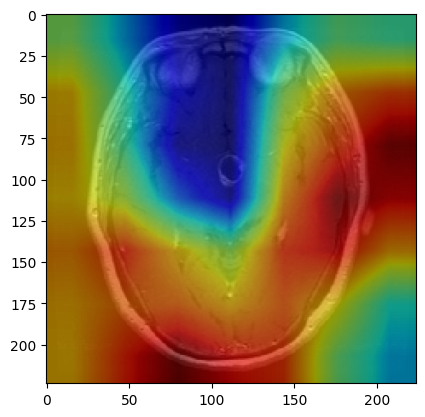

In [11]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(
    rescale=1/255,
    brightness_range=(0.8, 1.2),
    rotation_range=20,  # Adding rotation
    width_shift_range=0.2,  # Adding width shift
    height_shift_range=0.2,  # Adding height shift
    shear_range=0.2,  # Adding shear
    zoom_range=0.2,  # Adding zoom
    horizontal_flip=True,  # Adding horizontal flip
    fill_mode='nearest'
)


ts_gen = ImageDataGenerator(rescale=1/255)


train_gen = _gen.flow_from_dataframe(train_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)


test_gen = ts_gen.flow_from_dataframe(test_split_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)
#Load a pre-trained model (for example, MobileNetV2)
model = MobileNetV2(weights='imagenet')
img_path = 'C:/Users/arshdeep/Desktop/STUDY MATERIAL/third_Year/dataset/Testing/pituitary/Te-pi_0022.jpg'

# Load the image and resize to the target size (224, 224 for MobileNetV2)
img = image.load_img(img_path, target_size=(224, 224))  # Correct the target size
img_array = image.img_to_array(img)  # Convert the image to an array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image to [0, 1]

# Get the last convolutional layer
last_conv_layer = model.get_layer('Conv_1')

# Create a model that maps the input image to the activations of the last convolutional layer
grad_model = Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

# Get the gradient of the class with respect to the feature map of the last convolutional layer
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    loss = predictions[:, np.argmax(predictions[0])]  # Take the class with max probability

# Compute the gradient of the loss with respect to the feature map
grads = tape.gradient(loss, conv_outputs)

# Pool the gradients across the width and height of the feature map
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# Multiply each channel in the feature map by "how important this channel is"
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., np.newaxis]
heatmap = heatmap.numpy().reshape((conv_outputs.shape[0], conv_outputs.shape[1]))

# Normalize the heatmap between 0 and 1
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Resize the heatmap to the original image size
import cv2
heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))

# Create a heatmap overlay on the original image
plt.imshow(img)
plt.imshow(heatmap, alpha=0.6, cmap='jet')
plt.show()

## 2.4 Getting samples from data

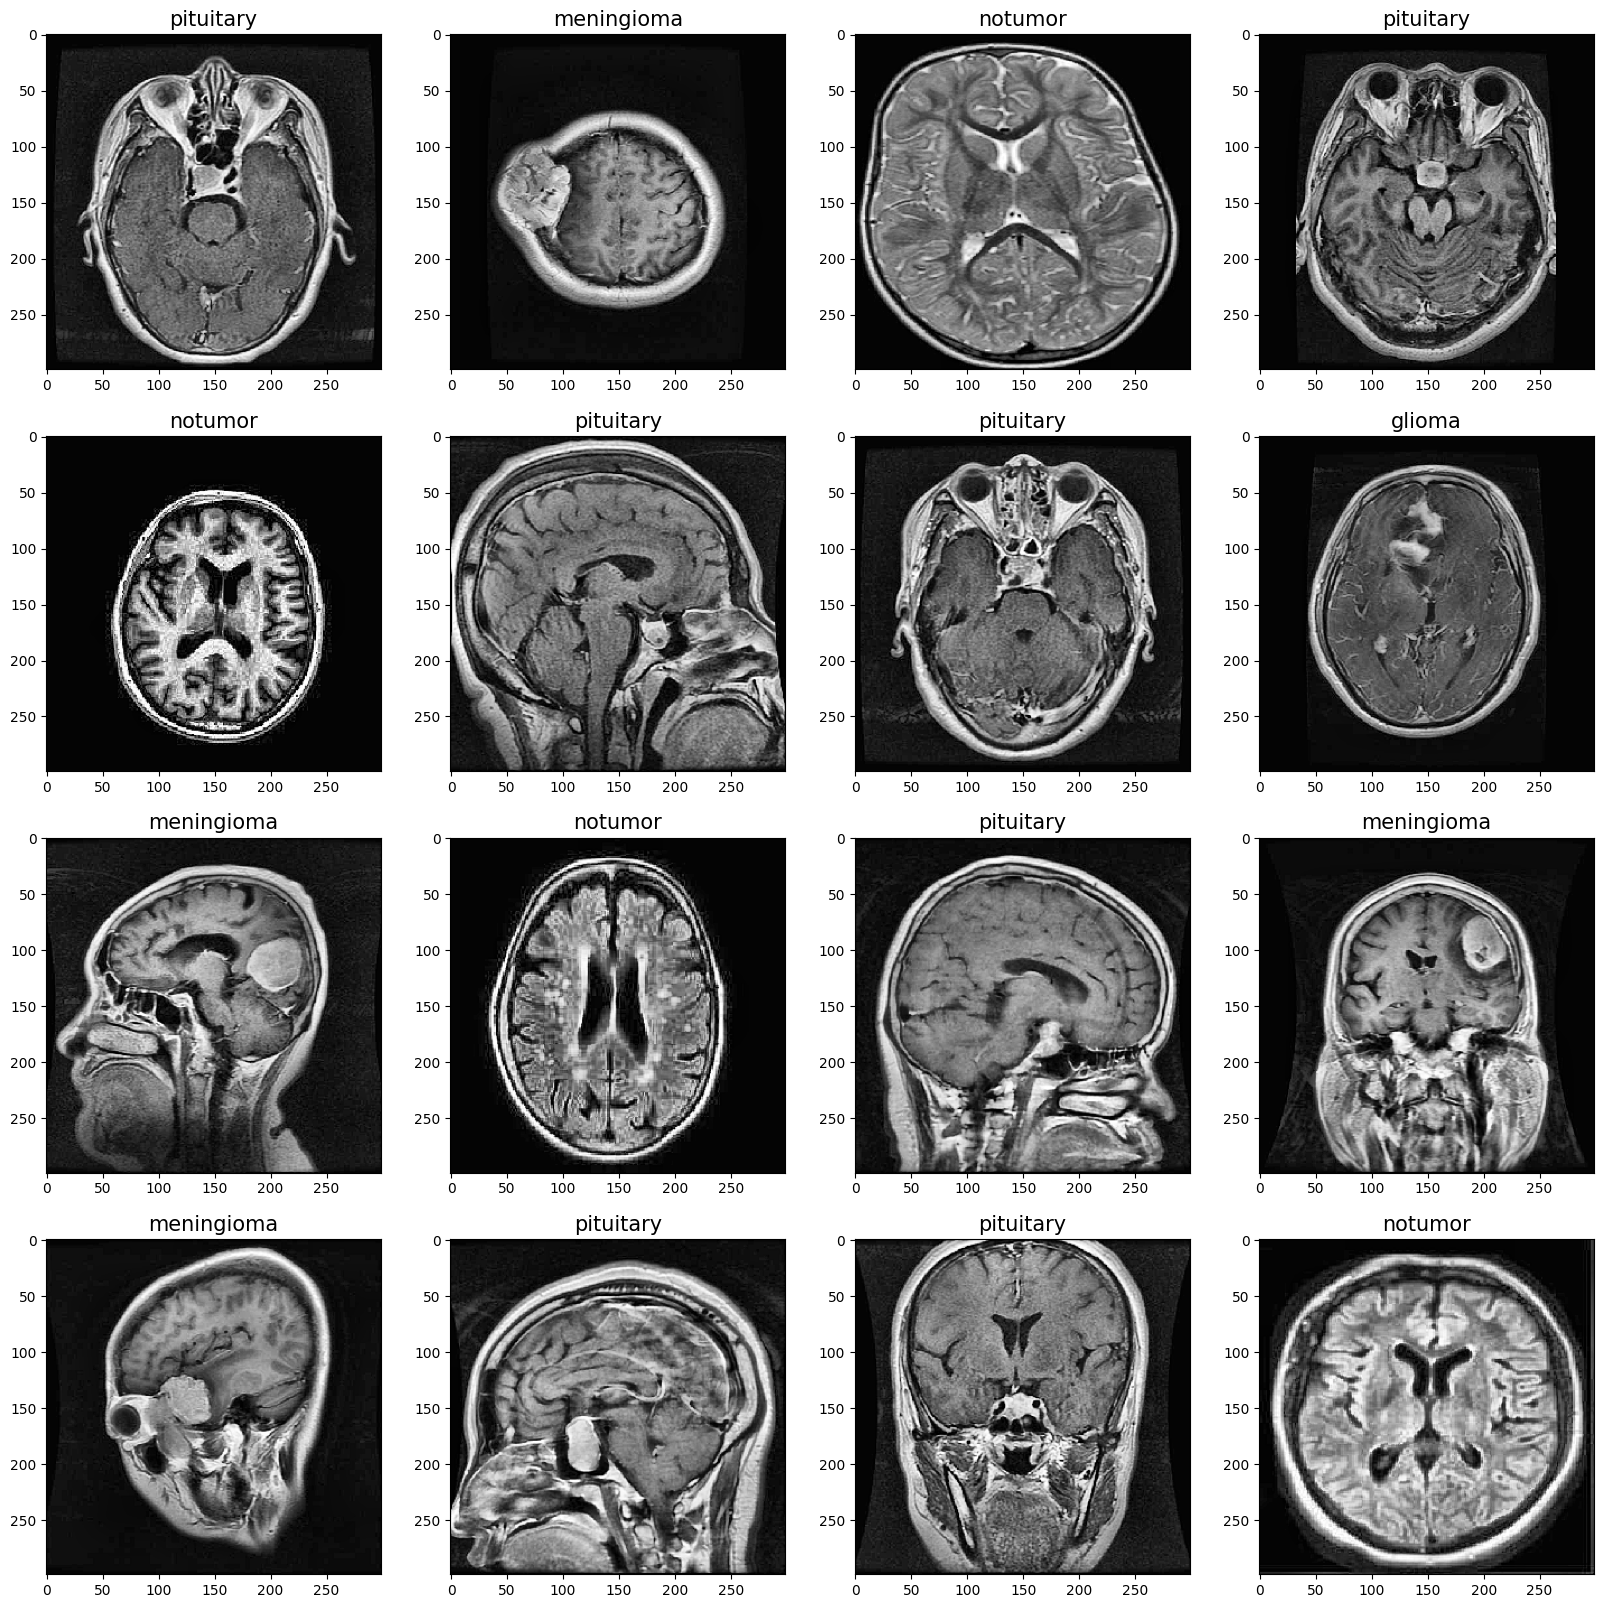

In [12]:

# Get class names
class_dict = train_gen.class_indices
classes = list(class_dict.keys())

# Load a batch of test images and labels
images, labels = next(test_gen)

# Function to enhance the image
def enhance_image(image):
    # Convert to grayscale for contrast enhancement (if needed)
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply CLAHE for local contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(gray_image)
    
    # Convert back to RGB after CLAHE
    enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB)
    
    # Apply unsharp masking for sharpening
    blurred = cv2.GaussianBlur(enhanced_image, (0, 0), 1.0)
    enhanced_image = cv2.addWeighted(enhanced_image, 1.5, blurred, -0.5, 0)
    
    return enhanced_image

# Figure setup for visualization
plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    # Convert image to uint8 format
    image = (image * 255).astype(np.uint8)
    
    # Enhance the image
    enhanced_image = enhance_image(image)
    
    # Display the enhanced image
    plt.subplot(4, 4, i + 1)
    plt.imshow(enhanced_image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()


# 3. Building Deep Learning Model

### Feature Extraction via MobileNet 

In [13]:
# Extract features using a pre-trained model 
feature_extractor = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(299, 299, 3), pooling='max')
feature_extractor.trainable = False 

# Extract features with caching
def extract_features(generator, save_path):
    if os.path.exists(save_path):
        print(f"Loading cached features from {save_path}")
        return np.load(save_path, allow_pickle=True)['features'], np.load(save_path, allow_pickle=True)['labels']
    
    features = []
    labels = []
    print(f"Extracting features...")
    for inputs_batch, labels_batch in generator:
        features_batch = feature_extractor.predict(inputs_batch)
        features.append(features_batch)
        labels.append(np.argmax(labels_batch, axis=1))  # Convert one-hot to integer labels
        if len(features) * generator.batch_size >= generator.n:
            break
    
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    np.savez(save_path, features=features, labels=labels)  # Cache features
    return features, labels

In [14]:
# Extract and cache features
train_features, train_labels = extract_features(train_gen, 'train_features.npz')
test_features, test_labels = extract_features(test_gen, 'test_features.npz')

Loading cached features from train_features.npz
Loading cached features from test_features.npz


## 3.1 S.V.M.

In [15]:
from sklearn.preprocessing import StandardScaler
# Apply Feature Scaling using StandardScaler
scaler = StandardScaler()

# Fit the scaler on training data and transform both training and test features
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Initialize SVM model
svm_model = svm.SVC(kernel='linear', C=1.0, probability=True)  # You can adjust the C parameter as needed

# Train the SVM classifier
svm_model.fit(train_features_scaled, train_labels)

# Assuming you are using an SVM model with a linear kernel
feature_importance = np.abs(svm_model.coef_[0])  # Get feature coefficients (absolute values)
feature_names = ['glioma', 'meningioma', 'notumor', 'pituitory'] 

# Make predictions on the training data
y_pred_train = svm_model.predict(train_features_scaled)
train_accuracy = accuracy_score(train_labels, y_pred_train)
train_precision = precision_score(train_labels, y_pred_train, average='macro')
train_recall = recall_score(train_labels, y_pred_train, average='macro')
train_f1 = f1_score(train_labels, y_pred_train, average='macro')

# Make predictions on the testing data
y_pred_test = svm_model.predict(test_features_scaled)
test_accuracy = accuracy_score(test_labels, y_pred_test)
test_precision = precision_score(test_labels, y_pred_test, average='macro')
test_recall = recall_score(test_labels, y_pred_test, average='macro')
test_f1 = f1_score(test_labels, y_pred_test, average='macro')

# Print the results
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Train Recall: {train_recall:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Train F1 Score: {train_f1:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Print the classification report for the test data
print("\nClassification Report (Test Data):")
print(classification_report(test_labels, y_pred_test))

# Optional - Cross-validation for more robust evaluation
cv_scores = cross_val_score(svm_model, train_features_scaled, train_labels, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")


Train Accuracy: 1.0000
Test Accuracy: 0.9300
Train Precision: 1.0000
Test Precision: 0.9274
Train Recall: 1.0000
Test Recall: 0.9274
Train F1 Score: 1.0000
Test F1 Score: 0.9274

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       396
           1       0.87      0.88      0.87       402
           2       0.98      0.97      0.98       479
           3       0.95      0.95      0.95       437

    accuracy                           0.93      1714
   macro avg       0.93      0.93      0.93      1714
weighted avg       0.93      0.93      0.93      1714

Cross-Validation Accuracy: 0.9155 (+/- 0.0025)


# 4. Training

## 4.1 Visualize model performance

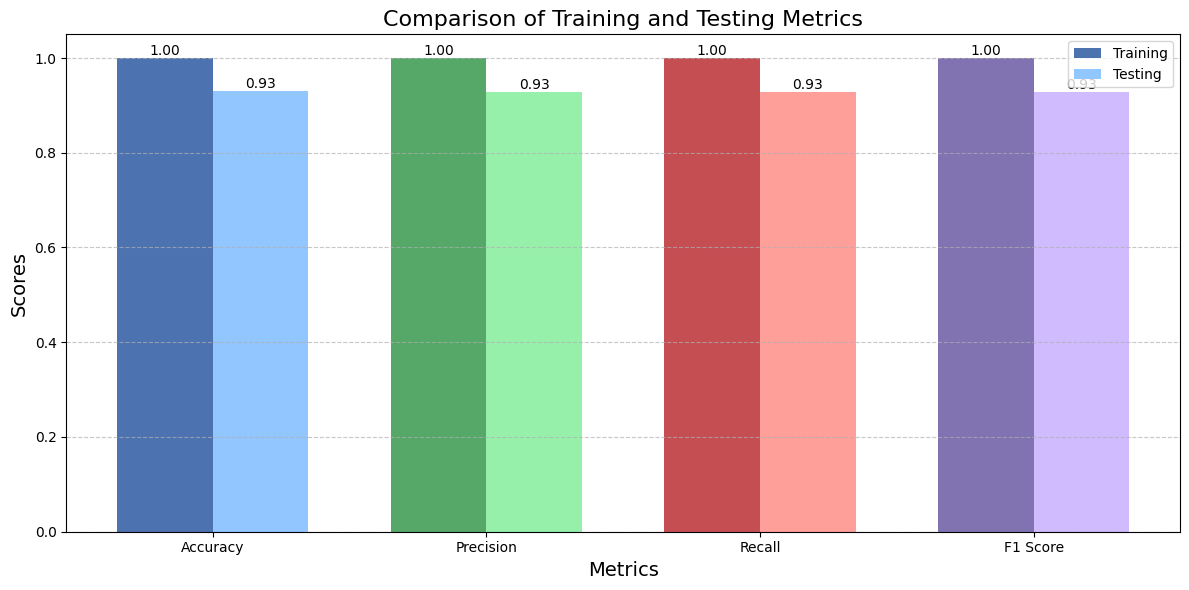

In [16]:
# Define the metrics and values for training and testing
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_metrics = [train_accuracy, train_precision, train_recall, train_f1]
test_metrics = [test_accuracy, test_precision, test_recall, test_f1]

# Define the number of metrics
num_metrics = len(metrics)

# Create an index for the positions of the bars
index = np.arange(num_metrics)

# Set the bar width
bar_width = 0.35

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the bars for training metrics
train_bars = plt.bar(index, train_metrics, bar_width, label='Training', color=['#4c72b0', '#55a868', '#c44e52', '#8172b2'])

# Plot the bars for testing metrics
test_bars = plt.bar(index + bar_width, test_metrics, bar_width, label='Testing', color=['#92c6ff', '#97f0aa', '#ff9f9a', '#d0bbff'])

# Add scores on top of training bars
for bar in train_bars:
    plt.annotate(f"{bar.get_height():.2f}",
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', va='bottom', fontsize=10, color='black')

# Add scores on top of testing bars
for bar in test_bars:
    plt.annotate(f"{bar.get_height():.2f}",
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', va='bottom', fontsize=10, color='black')

# Label the axes and add the title
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Comparison of Training and Testing Metrics', fontsize=16)

# Set the x-axis labels to be the metric names
plt.xticks(index + bar_width / 2, metrics)

# Add a legend
plt.legend()

# Display grid for better visibility
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()



# 5. Testing and Evaluation

## 5.1 Evaluate

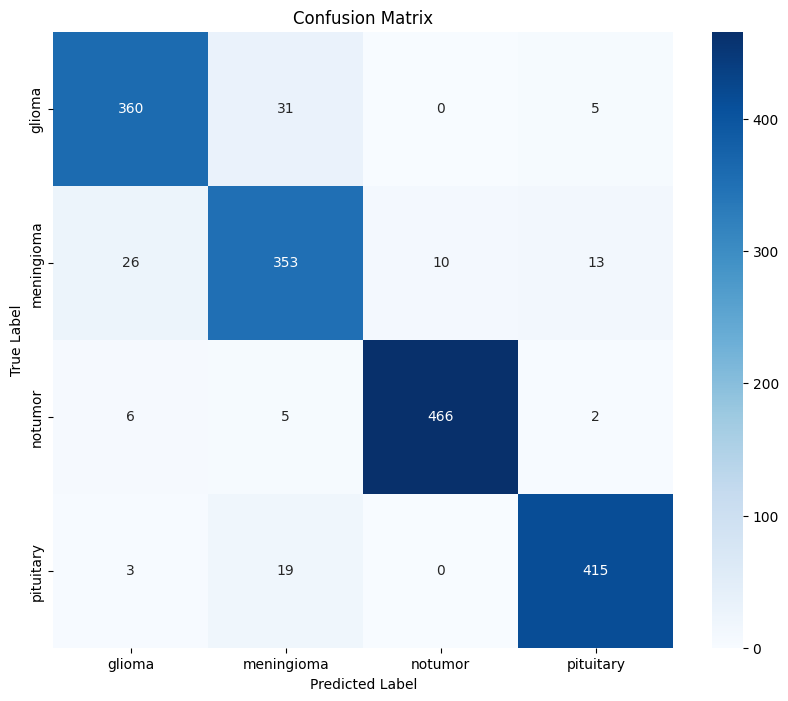

In [17]:
# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred_test)  # Use test_labels directly if it's a 1D array

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_gen.class_indices.keys(), yticklabels=train_gen.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## 5.2 Testing

In [18]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    from sklearn.preprocessing import LabelEncoder
    
    # Load the image and preprocess it
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))  # Resize to the input shape expected by Xception
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize the image
    
    # Extract features using the pre-trained model
    features = feature_extractor.predict(img)
    
    # Make predictions using the SVM model
    predictions = svm_model.predict(features)
    probs = svm_model.predict_proba(features)[0]
    
    # Decode the predictions to get the class names
    labels = list(train_gen.class_indices.keys())
    label_encoder = LabelEncoder()
    label_encoder.fit(labels)
    predicted_class = label_encoder.inverse_transform([predictions[0]])[0]
    
    # Plot the image and the predictions
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.title(f"Predicted: {predicted_class}", fontsize=16)
    
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt='%.2f')
    plt.show()

# Example usage:
# predict('path_to_image.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


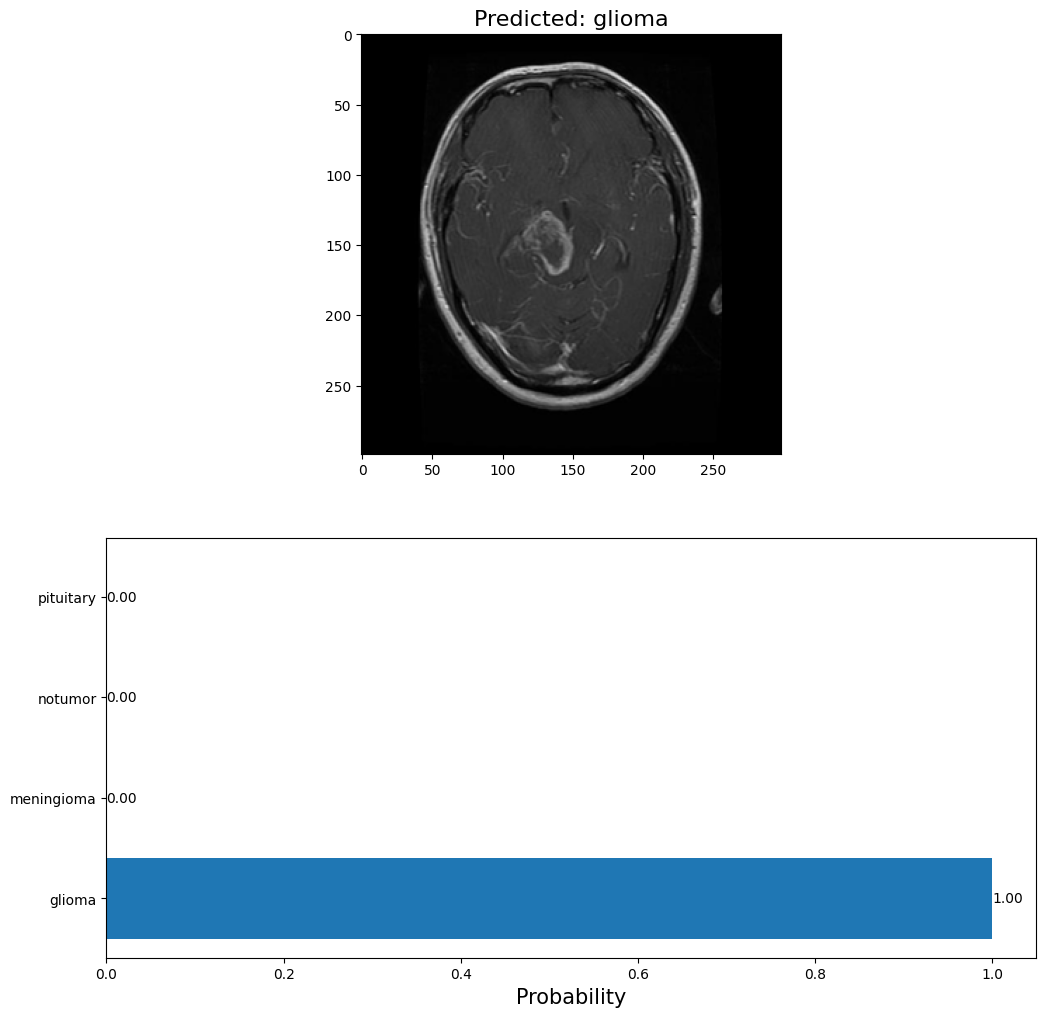

In [19]:
predict('C:/Users/arshdeep/Desktop/STUDY MATERIAL/third_Year/dataset/Testing/glioma/Te-gl_0026.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


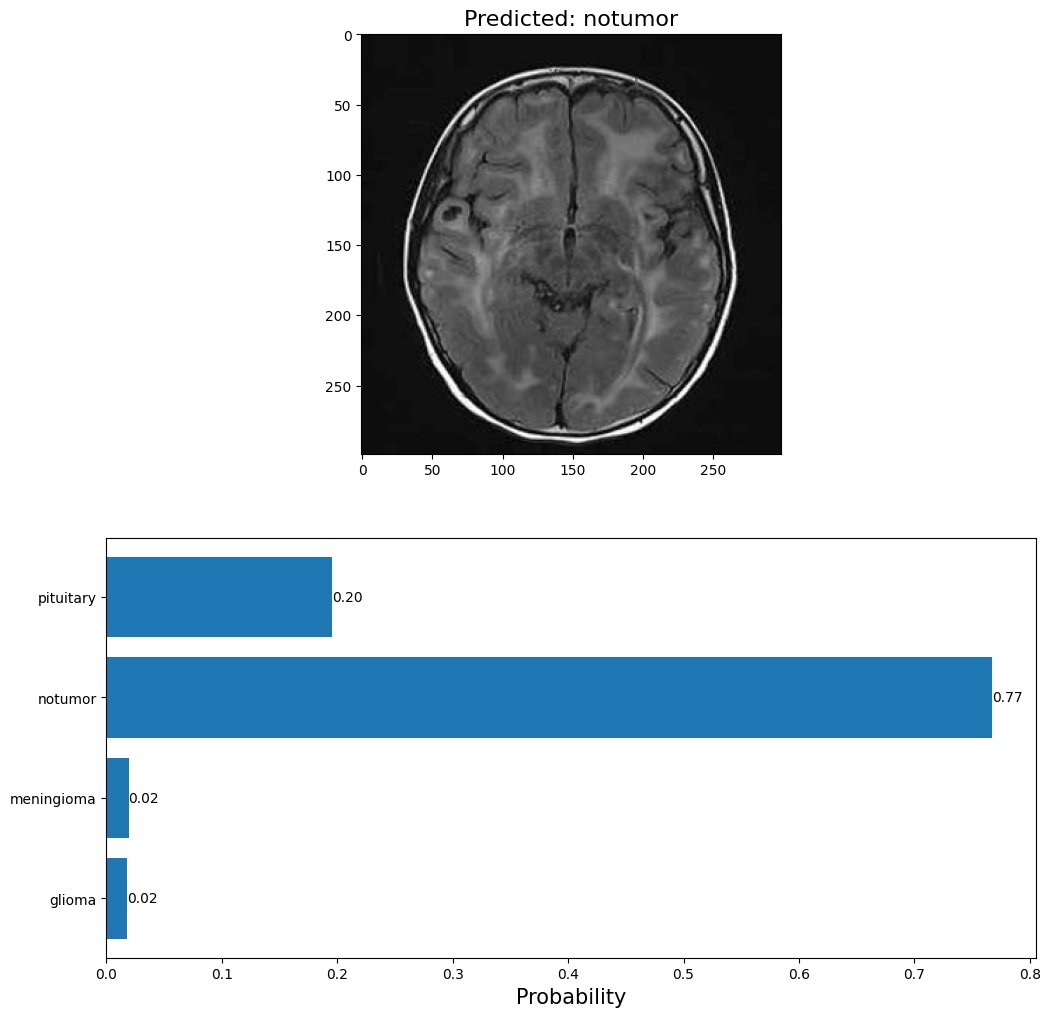

In [20]:
predict('C:/Users/arshdeep/Desktop/STUDY MATERIAL/third_Year/dataset/Testing/notumor/Te-no_0019.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


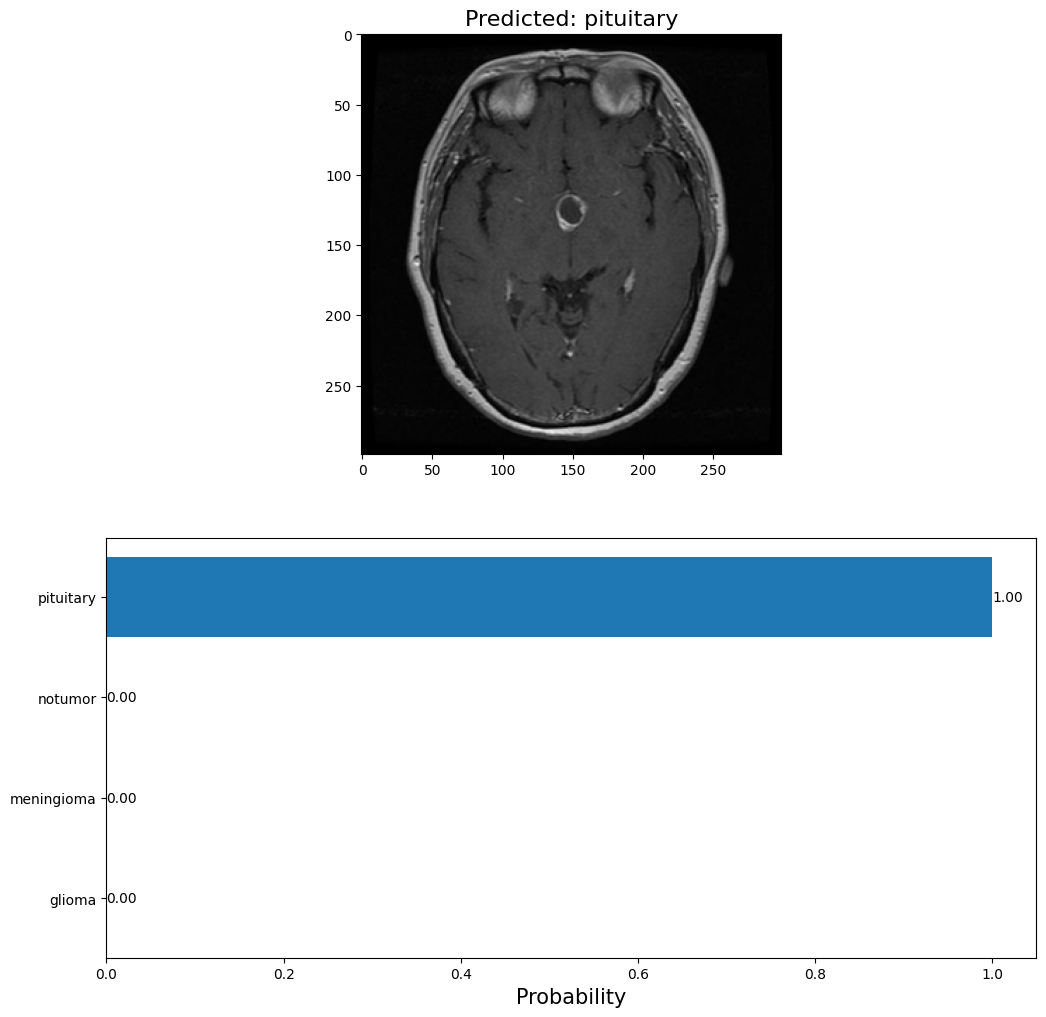

In [21]:
predict('C:/Users/arshdeep/Desktop/STUDY MATERIAL/third_Year/dataset/Testing/pituitary/Te-pi_0022.jpg')

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true labels for multi-class
y_true = label_binarize(test_labels, classes=[0, 1, 2, 3])  # Adjust the classes according to your dataset
y_score = svm_model.predict_proba(test_features)  # Model output for the test set

# Calculate ROC and AUC for each class
n_classes = y_true.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate micro and macro AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


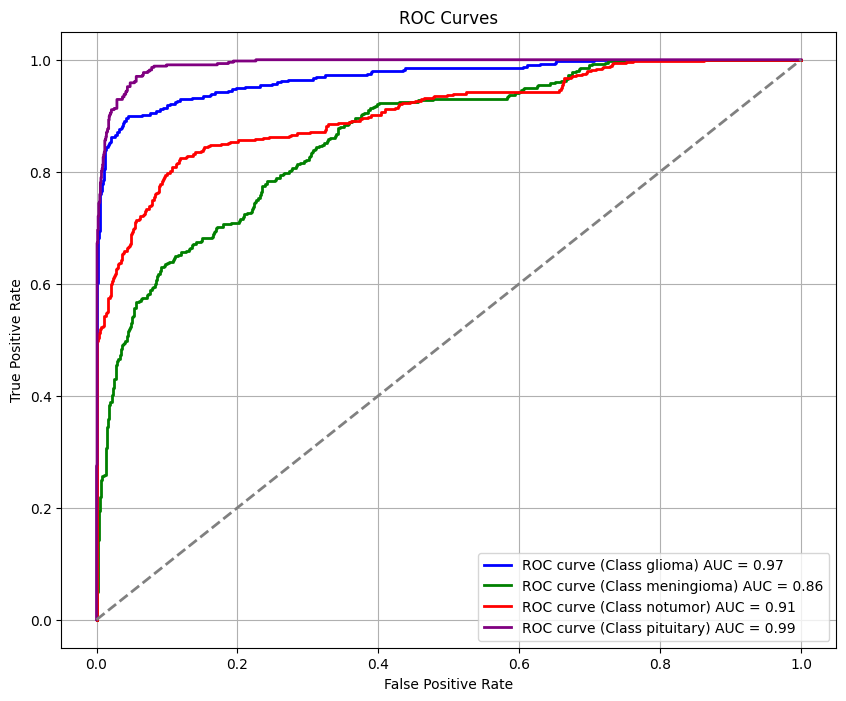

In [23]:
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple']  # Change according to the number of classes

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (Class {classes[i]}) AUC = {roc_auc[i]:.2f}')
    
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [24]:
feature_extractor.save('feature_extractor_mri.keras')
